# Anggota Kelompok:
- Paul Jonathan - 2702252701
- Marcel Lius Vincent Candra - 2702277143

# Import Libraries
---

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

import os
%matplotlib inline

plt.rcParams['figure.figsize'] = 12, 8

In [7]:
tf.__version__, np.__version__, pd.__version__, nltk.__version__, sklearn.__version__, hub.__version__

('2.10.1', '1.23.5', '2.0.3', '3.9.2', '1.2.2', '0.16.1')

In [8]:
RANDOM_SEED = 42

In [9]:
tf.config.run_functions_eagerly(True)

In [10]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
use = hub.load(module_url)

# Load dataset
---

dataset: https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe?resource=download

In [11]:
df = pd.read_csv('Hotel_Reviews.csv')
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


# EDA
---

In [12]:
f'{df.shape[0]} rows, {df.shape[1]} columns'

'515738 rows, 17 columns'

In [13]:
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Additional_Number_of_Scoring,515738.0,498.081836,500.538467,1.000000,169.000000,341.000000,660.000000,2682.000000
Average_Score,515738.0,8.397487,0.548048,5.200000,8.100000,8.400000,8.800000,9.800000
Review_Total_Negative_Word_Counts,515738.0,18.539450,29.690831,0.000000,2.000000,9.000000,23.000000,408.000000
Total_Number_of_Reviews,515738.0,2743.743944,2317.464868,43.000000,1161.000000,2134.000000,3613.000000,16670.000000
Review_Total_Positive_Word_Counts,515738.0,17.776458,21.804185,0.000000,5.000000,11.000000,22.000000,395.000000
Total_Number_of_Reviews_Reviewer_Has_Given,515738.0,7.166001,11.040228,1.000000,1.000000,3.000000,8.000000,355.000000
Reviewer_Score,515738.0,8.395077,1.637856,2.500000,7.500000,8.800000,9.600000,10.000000
lat,512470.0,49.442439,3.466325,41.328376,48.214662,51.499981,51.516288,52.400181
lng,512470.0,2.823803,4.579425,-0.369758,-0.143372,0.010607,4.834443,16.429233


In [16]:
df.describe(include='object').T

,count,unique,top,freq
Hotel_Address,515738,1493,163 Marsh Wall Docklands Tower Hamlets London ...,4789
Review_Date,515738,731,8/2/2017,2585
Hotel_Name,515738,1492,Britannia International Hotel Canary Wharf,4789
Reviewer_Nationality,515738,227,United Kingdom,245246
Negative_Review,515738,330011,No Negative,127890
Positive_Review,515738,412601,No Positive,35946
Tags,515738,55242,"[' Leisure trip ', ' Couple ', ' Double Room '...",5101
days_since_review,515738,731,1 days,2585


In [17]:
df.Reviewer_Score.describe()

count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: Reviewer_Score, dtype: float64

Text(0.5, 1.0, 'Review Score Distribution')

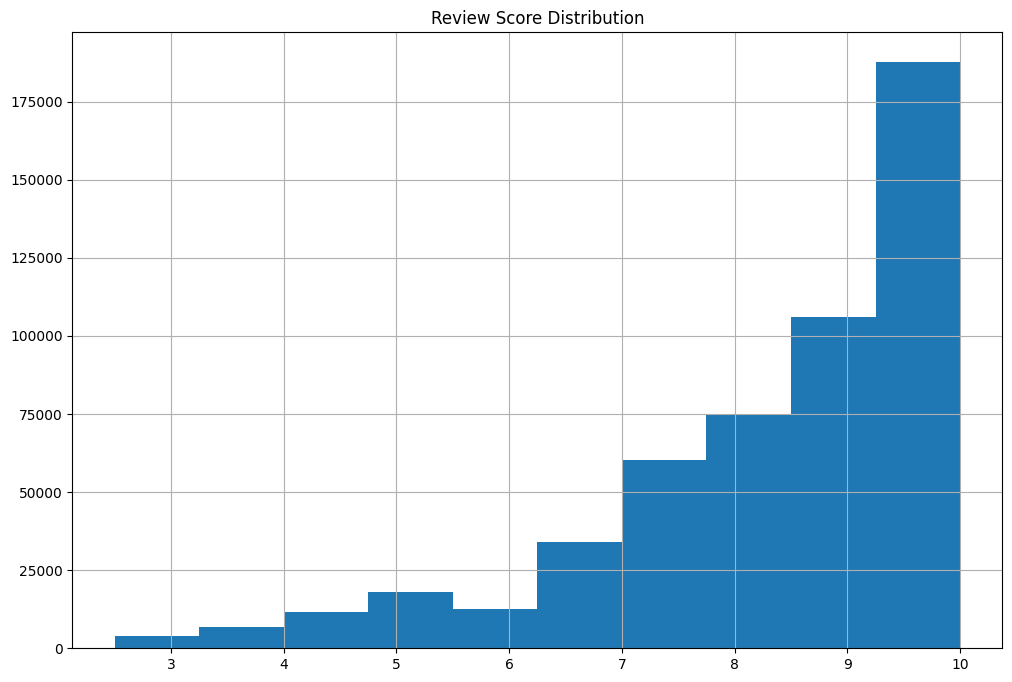

In [18]:
df.Reviewer_Score.hist()
plt.title('Review Score Distribution')

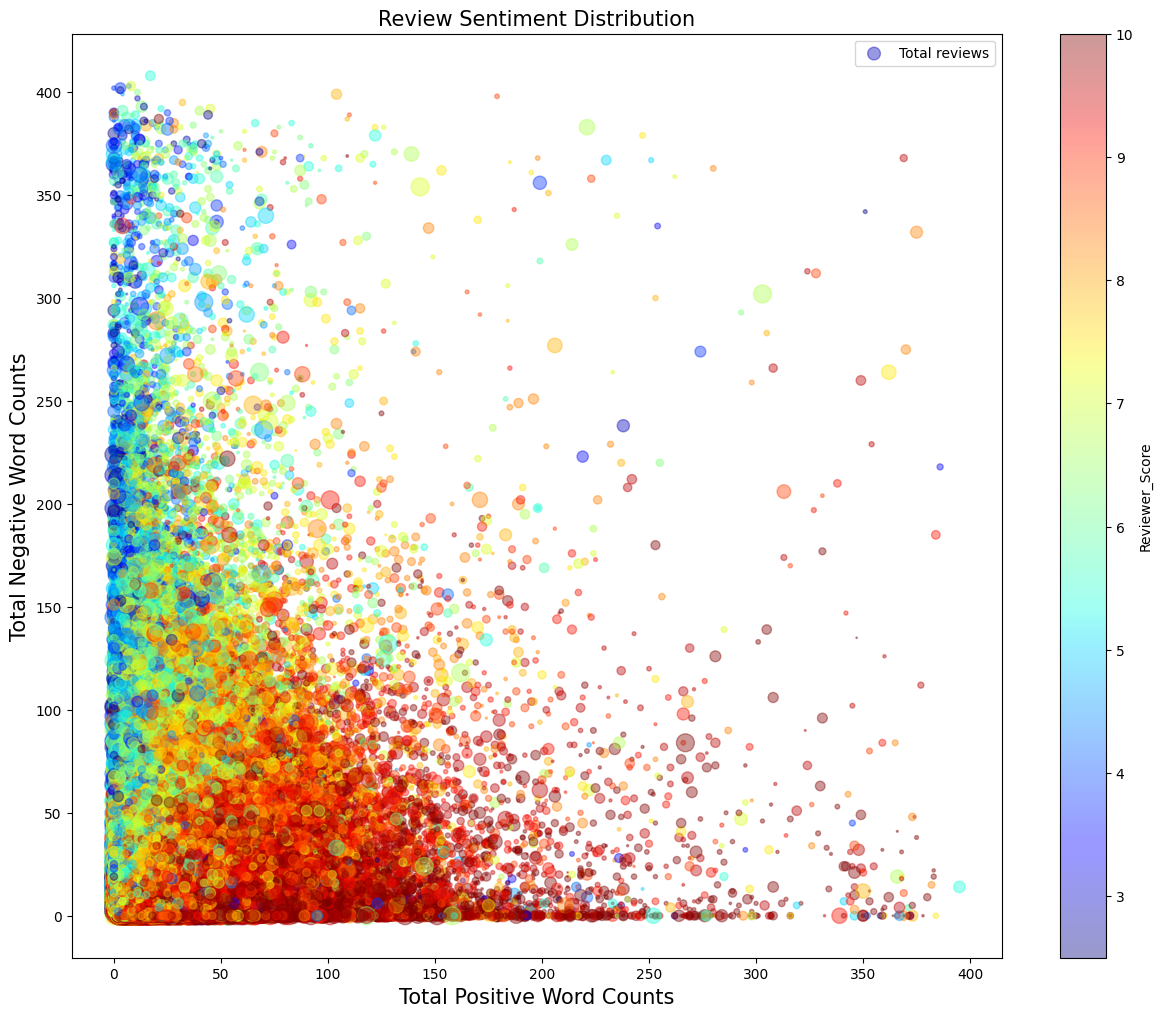

In [19]:
df.plot(kind='scatter', 
                      x='Review_Total_Positive_Word_Counts', 
                      y='Review_Total_Negative_Word_Counts', 
                      label='Total reviews',
             s=df.Total_Number_of_Reviews/100,
             c='Reviewer_Score',
             cmap=plt.get_cmap('jet'), 
             colorbar=True, 
             alpha=0.4, figsize=(15,12),
             sharex=False, 
             )
font_size = 15
plt.title("Review Sentiment Distribution",  fontsize=font_size)
plt.xlabel("Total Positive Word Counts", fontsize=font_size)
plt.ylabel("Total Negative Word Counts",  fontsize=font_size)
plt.legend()
plt.show()
     

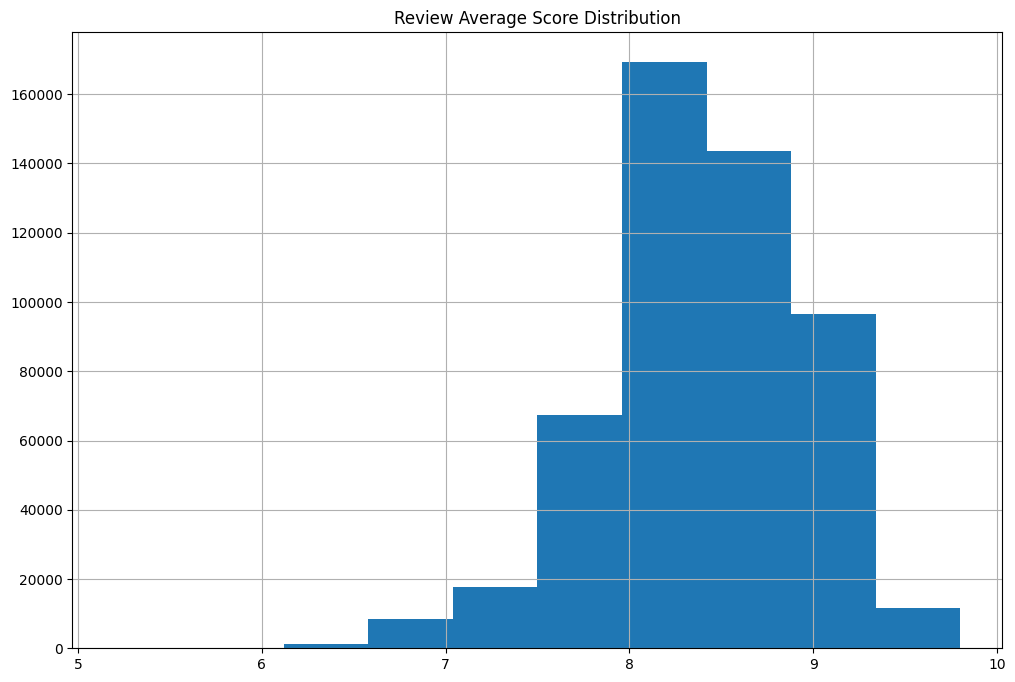

In [20]:
df.Average_Score.hist()
plt.title('Review Average Score Distribution');

## Clean Review Text

In [21]:
df.loc[df['Positive_Review'] == 'No Positive']

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
8,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/9/2017,7.7,Hotel Arena,Belgium,Even though the pictures show very clean room...,34,1403,No Positive,0,3,6.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",25 days,52.360576,4.915968
32,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,5/11/2017,7.7,Hotel Arena,United States of America,Our bathroom had an urine order Shower was ve...,68,1403,No Positive,0,1,4.2,"[' Leisure trip ', ' Group ', ' Duplex Twin Ro...",84 days,52.360576,4.915968
98,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,9/19/2016,7.7,Hotel Arena,United Kingdom,Got charged 50 for a birthday package when it...,112,1403,No Positive,0,1,5.0,"[' Leisure trip ', ' Couple ', ' Large King Ro...",318 day,52.360576,4.915968
121,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,6/1/2016,7.7,Hotel Arena,United States of America,The first room had steep steps to a loft bed ...,39,1403,No Positive,0,12,8.3,"[' Leisure trip ', ' Couple ', ' Duplex Double...",428 day,52.360576,4.915968
134,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,5/1/2016,7.7,Hotel Arena,Australia,Foyer was a mess Only place to relax was the ...,180,1403,No Positive,0,6,4.6,"[' Leisure trip ', ' Couple ', ' Duplex Double...",459 day,52.360576,4.915968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515666,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,9/20/2016,8.1,Atlantis Hotel Vienna,Belgium,Noise from the air conditioning system imposs...,11,2823,No Positive,0,19,6.3,"[' Family with young children ', ' Family Room...",317 day,48.203745,16.335677
515688,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,7/11/2016,8.1,Atlantis Hotel Vienna,Romania,Parking to expensive and so is the breakfast,9,2823,No Positive,0,2,7.5,"[' Couple ', ' Standard Double or Twin Room ',...",388 day,48.203745,16.335677
515695,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,6/27/2016,8.1,Atlantis Hotel Vienna,South Korea,dust towel,3,2823,No Positive,0,2,7.1,"[' Leisure trip ', ' Solo traveler ', ' Standa...",402 day,48.203745,16.335677
515700,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,5/29/2016,8.1,Atlantis Hotel Vienna,Russia,Room vas located in different building with n...,25,2823,No Positive,0,2,3.8,"[' Business trip ', ' Solo traveler ', ' Stand...",431 day,48.203745,16.335677


In [22]:
df.loc[df['Negative_Review'] == 'No Negative']

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
13,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/4/2017,7.7,Hotel Arena,Italy,No Negative,0,1403,This hotel is being renovated with great care...,59,6,9.2,"[' Business trip ', ' Solo traveler ', ' Duple...",30 days,52.360576,4.915968
15,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/3/2017,7.7,Hotel Arena,Italy,No Negative,0,1403,This hotel is awesome I took it sincirely bec...,82,26,10.0,"[' Leisure trip ', ' Couple ', ' Duplex Double...",31 days,52.360576,4.915968
18,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,6/29/2017,7.7,Hotel Arena,Netherlands,No Negative,0,1403,Public areas are lovely and the room was nice...,33,4,7.1,"[' Business trip ', ' Group ', ' Duplex Double...",35 days,52.360576,4.915968
48,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,3/22/2017,7.7,Hotel Arena,United Kingdom,No Negative,0,1403,The quality of the hotel was brilliant and ev...,77,3,10.0,"[' Leisure trip ', ' Couple ', ' Duplex Double...",134 day,52.360576,4.915968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515723,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,11/15/2015,8.1,Atlantis Hotel Vienna,Croatia,No Negative,0,2823,Second to none location if you re off to Stad...,23,1,8.8,"[' Leisure trip ', ' Group ', ' Standard Tripl...",627 day,48.203745,16.335677
515724,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,10/27/2015,8.1,Atlantis Hotel Vienna,India,No Negative,0,2823,Only location little far away from City,9,7,8.3,"[' Leisure trip ', ' Family with young childre...",646 day,48.203745,16.335677
515729,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,9/26/2015,8.1,Atlantis Hotel Vienna,Brazil,No Negative,0,2823,The breakfast was excelent lots of fress frui...,27,7,10.0,"[' Leisure trip ', ' Couple ', ' Standard Doub...",677 day,48.203745,16.335677
515732,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,9/6/2015,8.1,Atlantis Hotel Vienna,Kuwait,No Negative,0,2823,helpful staff allowed me to check in early as...,18,6,10.0,"[' Leisure trip ', ' Family with young childre...",697 day,48.203745,16.335677


In [23]:
df.loc[:, 'Positive_Review'] = df.Positive_Review.apply(lambda x: x.replace('No Positive', ''))
df.loc[:, 'Negative_Review'] = df.Negative_Review.apply(lambda x: x.replace('No Negative', ''))
     

In [24]:
df['Negative_Review'][1]

''

## Merge both review texts

In [25]:
df['Review'] = df.Positive_Review + df.Negative_Review

## Set Sentiment Types

In [26]:
df['Review_type'] = df['Reviewer_Score'].apply(lambda x: 'bad' if x < 7 else 'good')

In [27]:
df_reviews = df[['Review', 'Review_type']]

In [28]:
df_reviews.head(10)

,Review,Review_type
0,Only the park outside of the hotel was beauti...,bad
1,No real complaints the hotel was great great ...,good
2,Location was good and staff were ok It is cut...,good
3,Great location in nice surroundings the bar a...,bad
4,Amazing location and building Romantic settin...,bad
5,Good restaurant with modern design great chil...,bad
6,The room is spacious and bright The hotel is ...,bad
7,Good location Set in a lovely park friendly s...,good
8,Even though the pictures show very clean room...,bad
9,The room was big enough and the bed is good T...,good


<Axes: >

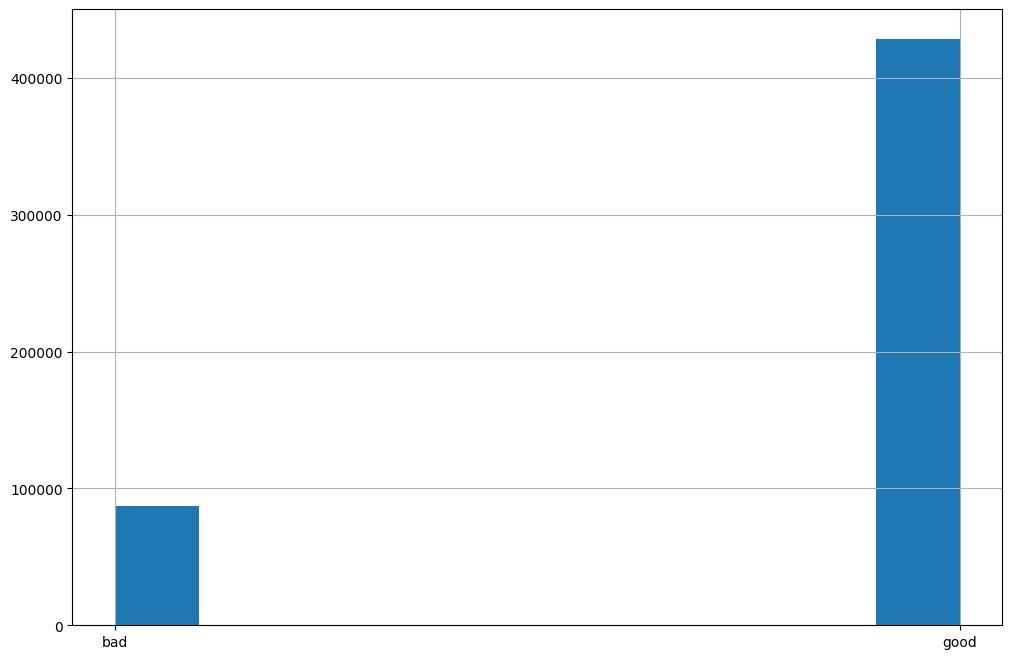

In [29]:
df_reviews.Review_type.hist()

In [30]:
df_reviews[df_reviews.Review_type == 'good'].Review.value_counts()

Review
 Location                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           947
 Everything Nothing                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 938
 Everything      

In [31]:
df_reviews[df_reviews.Review_type == 'bad'].Review.value_counts()

Review
 Nothing Everything                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  124
 Location                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [32]:
good_reviews = df_reviews[df_reviews.Review_type == "good"]
bad_reviews = df_reviews[df_reviews.Review_type == "bad"]

In [33]:
good_reviews.head()

,Review,Review_type
1,No real complaints the hotel was great great ...,good
2,Location was good and staff were ok It is cut...,good
7,Good location Set in a lovely park friendly s...,good
9,The room was big enough and the bed is good T...,good
10,Rooms were stunningly decorated and really sp...,good


In [34]:
bad_reviews.head()

,Review,Review_type
0,Only the park outside of the hotel was beauti...,bad
3,Great location in nice surroundings the bar a...,bad
4,Amazing location and building Romantic settin...,bad
5,Good restaurant with modern design great chil...,bad
6,The room is spacious and bright The hotel is ...,bad


In [35]:
good_reviews_text = " ".join(good_reviews.Review.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.Review.to_numpy().tolist())

In [36]:
def gen_wc(txt):
  stopwords = set(STOPWORDS) 
  wc = WordCloud(width=800, height=400,background_color="white", max_font_size=300, stopwords = stopwords).generate(txt)
  plt.figure(figsize=(14,10))
  plt.imshow(wc, interpolation="bilinear")
  plt.axis('off')
  plt.show()

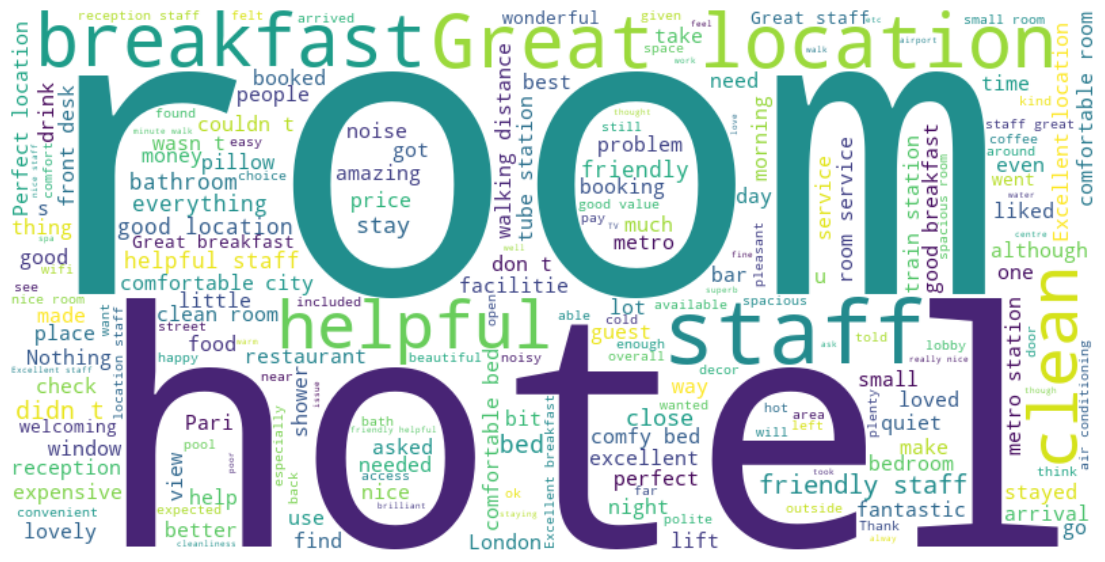

In [37]:
gen_wc(good_reviews_text)

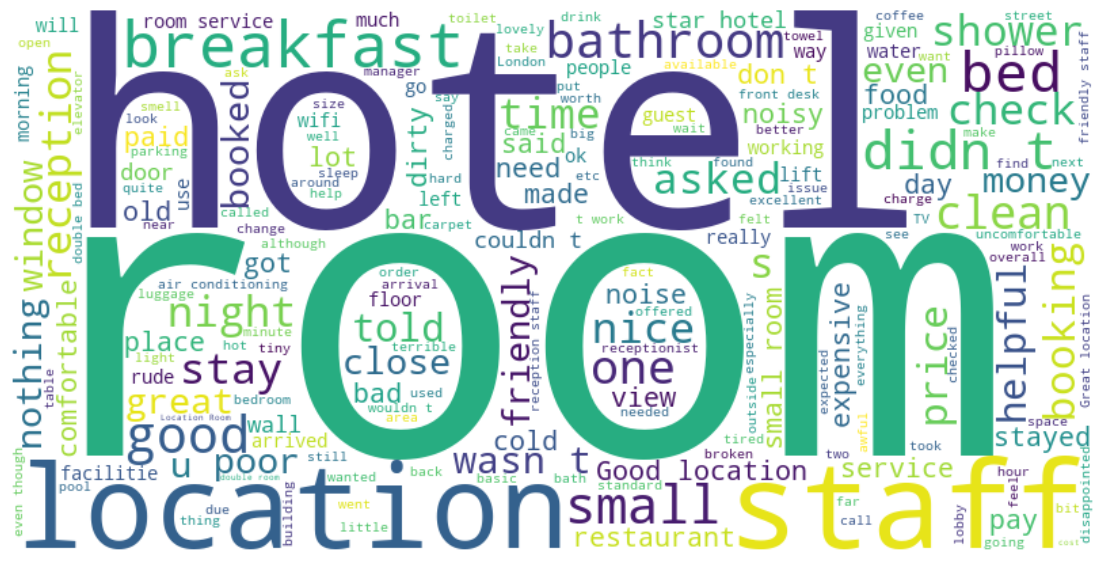

In [38]:
gen_wc(bad_reviews_text)

## Resampling

In [39]:
good_df = good_reviews.sample(n=len(bad_reviews), random_state=RANDOM_SEED)

df_review_resampled = pd.concat([good_df, bad_reviews], axis=0).reset_index(drop=True)
df_review_resampled.shape

(173702, 2)

In [40]:
df_review_resampled.head()

,Review,Review_type
0,Location was excellent rooms were extremely c...,good
1,very comfortable bed excellent air con great ...,good
2,The views,good
3,Clean and comfortable room Kettle and selecti...,good
4,Beds comfy staff lovely food amazing room spa...,good


Text(0.5, 1.0, 'Review type (resampled)')

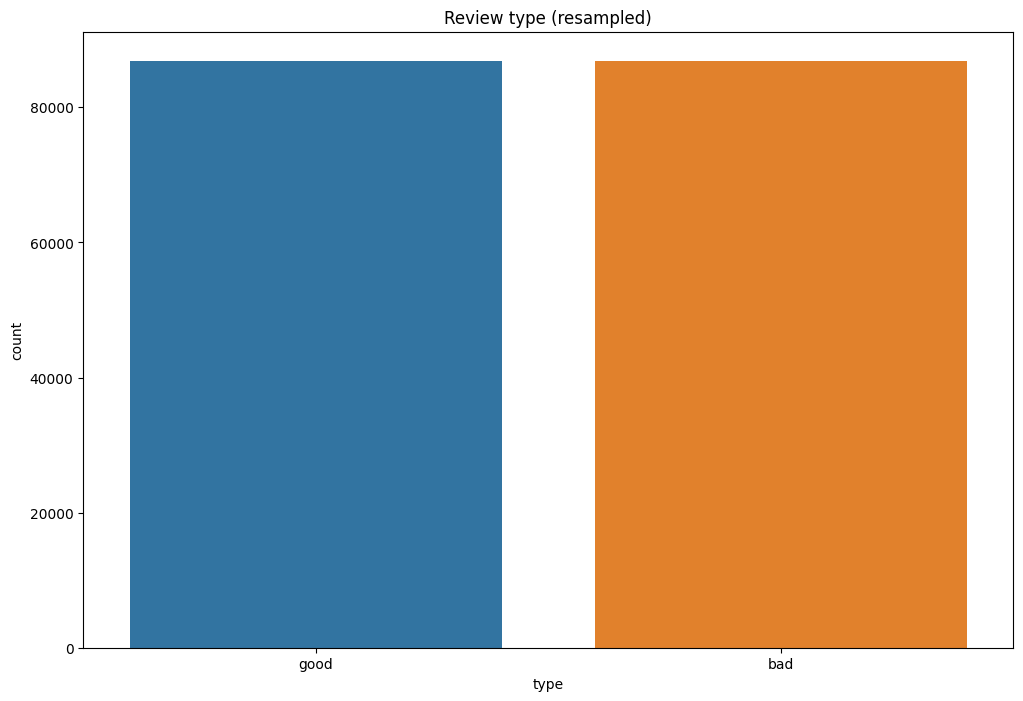

In [41]:
sns.countplot(
  x='Review_type',
  data=df_review_resampled,
  order=df_review_resampled.Review_type.value_counts().index,
)

plt.xlabel("type")
plt.title("Review type (resampled)")

# Data Preparation
---

In [42]:
label_enc = LabelEncoder()
encoded_review = label_enc.fit_transform(df_review_resampled.Review_type.values)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df_review_resampled.Review, encoded_review, test_size=0.2, random_state=RANDOM_SEED)

# Modelling
---

## Word Vectors

In [44]:
X_train_emb = []
for r in tqdm(X_train):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train_emb.append(review_emb)

100%|██████████| 138961/138961 [1:38:21<00:00, 23.55it/s]


In [45]:
X_train_emb = np.array(X_train_emb)

In [46]:
X_test_emb = []
for r in tqdm(X_test):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test_emb.append(review_emb)

X_test_emb = np.array(X_test_emb)

100%|██████████| 34741/34741 [17:04<00:00, 33.90it/s]


In [47]:
# plot accuracy and loss helper func
def plot_history(history):
  accuracy = history.history['accuracy']
  val_accuracy= history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, label='Training accuracy')
  plt.plot(epochs, val_accuracy, label='Validation accuracy')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

# NN

In [ ]:
def build_model_baseNN():
  model = Sequential()
  model.add(Dense(256, activation='relu', input_shape=(X_train_emb.shape[1],)))
  model.add(Dropout(0.25))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.001))
  return model

In [49]:
print(X_train.shape)

(138961,)


In [50]:
model_nn = build_model_baseNN()
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 164,353
Trainable params: 164,353
Non-trainable params: 0
_________________________________________________________________


In [51]:
history_nn = model_nn.fit(
    X_train_emb, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10


c:\Users\LEGION\anaconda3\envs\sentiment-analysis-dl\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7817/7817 [==============================] - 153s 20ms/step - loss: 0.4282 - accuracy: 0.7975 - val_loss: 0.4096 - val_accuracy: 0.8089
Epoch 2/10
7817/7817 [==============================] - 150s 19ms/step - loss: 0.4044 - accuracy: 0.8117 - val_loss: 0.4034 - val_accuracy: 0.8120
Epoch 3/10
7817/7817 [==============================] - 148s 19ms/step - loss: 0.3921 - accuracy: 0.8198 - val_loss: 0.3990 - val_accuracy: 0.8136
Epoch 4/10
7817/7817 [==============================] - 146s 19ms/step - loss: 0.3818 - accuracy: 0.8251 - val_loss: 0.3969 - val_accuracy: 0.8149
Epoch 5/10
7817/7817 [==============================] - 148s 19ms/step - loss: 0.3712 - accuracy: 0.8312 - val_loss: 0.3960 - val_accuracy: 0.8126
Epoch 6/10
7817/7817 [==============================] - 148s 19ms/step - loss: 0.3598 - accuracy: 0.8375 - val_loss: 0.3993 - val_accuracy: 0.8154
Epoch 7/10
7817/7817 [==============================] - 152s 19ms/step - loss: 0.3490 - accuracy: 0.8423 - val_loss: 0.4058 - val

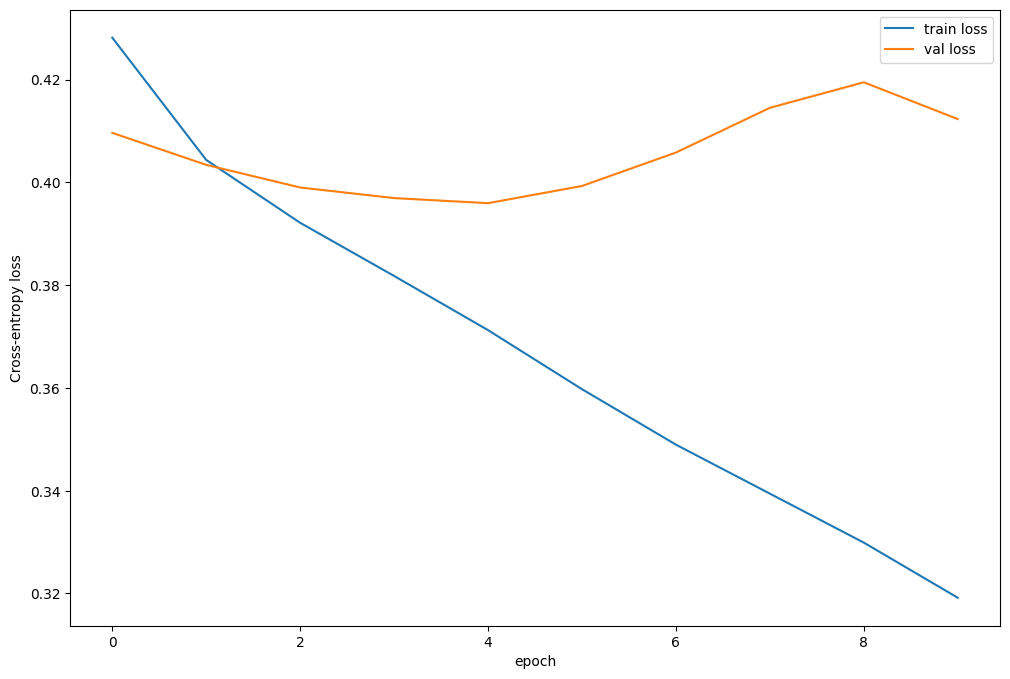

In [52]:
plt.plot(history_nn.history['loss'], label='train loss')
plt.plot(history_nn.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend()

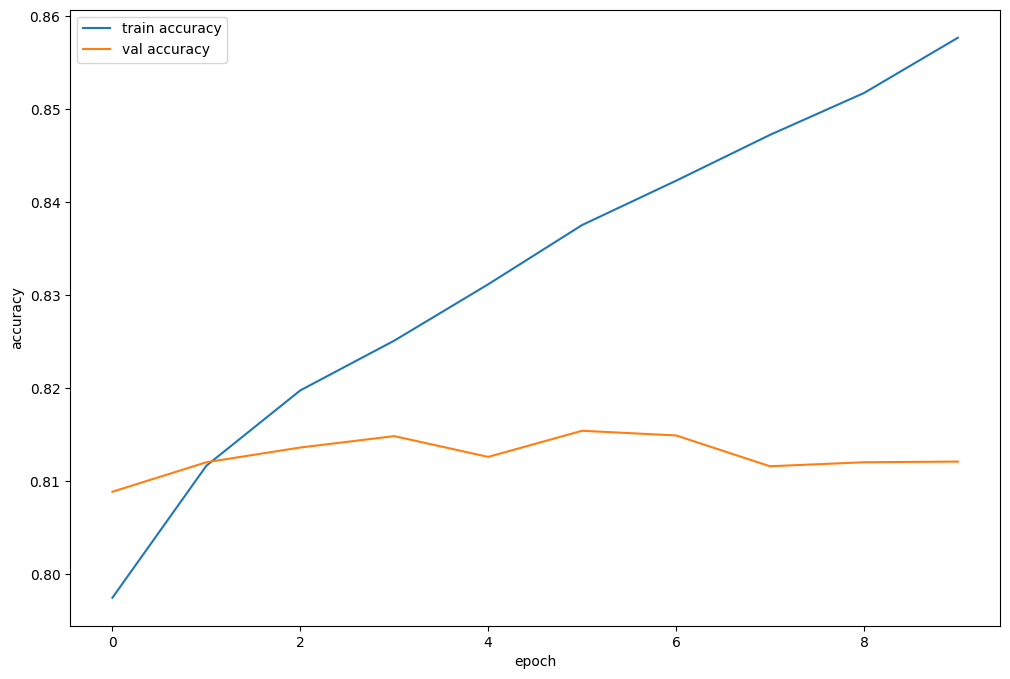

In [53]:
plt.plot(history_nn.history['accuracy'], label='train accuracy')
plt.plot(history_nn.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

In [92]:
test_loss_nn, test_accuracy_nn =model_nn.evaluate(X_test_emb, y_test)
print(f"Test accuracy: {test_accuracy_nn}, Test loss: {test_loss_nn}")

   8/1086 [..............................] - ETA: 8s - loss: 0.5470 - accuracy: 0.7539 

c:\Users\LEGION\anaconda3\envs\sentiment-analysis-dl\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1086/1086 [==============================] - 11s 10ms/step - loss: 0.4261 - accuracy: 0.8109
Test accuracy: 0.8109150528907776, Test loss: 0.4261264503002167


In [96]:
print(f"Test accuracy: {test_accuracy_nn * 100:.3f}, Test loss: {test_loss_nn * 100:.3f}")

Test accuracy: 81.092, Test loss: 42.613


# LSTM ver1

In [55]:
y_train.shape

(138961,)

In [56]:
X_train_reshaped = X_train_emb[:, np.newaxis,:]
X_test_reshaped = X_test_emb[:, np.newaxis,:]
y_train_reshaped = y_train[:, np.newaxis, np.newaxis]
y_test_reshaped = y_test[:, np.newaxis, np.newaxis]

In [57]:
y_train_reshaped.shape

(138961, 1, 1)

In [58]:
1, X_train_reshaped.shape[2]

(1, 512)

In [59]:
def build_model_lstm_1():
  model = Sequential()
  model.add(LSTM(256, activation='sigmoid', return_sequences=True,
                 input_shape=(1,X_train_reshaped.shape[2])
                 ))

  model.add(Dense(128, activation='relu'))

  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.0005))
  return model

In [60]:
model_lstm_1 = build_model_lstm_1()
model_lstm_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 256)            787456    
                                                                 
 dense_3 (Dense)             (None, 1, 128)            32896     
                                                                 
 dense_4 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 820,481
Trainable params: 820,481
Non-trainable params: 0
_________________________________________________________________


In [61]:
history_lstm_1 = model_lstm_1.fit(
    X_train_reshaped, y_train_reshaped, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
7817/7817 [==============================] - 208s 27ms/step - loss: 0.4498 - accuracy: 0.7850 - val_loss: 0.4398 - val_accuracy: 0.7948
Epoch 2/10
7817/7817 [==============================] - 216s 28ms/step - loss: 0.4245 - accuracy: 0.7987 - val_loss: 0.4340 - val_accuracy: 0.7928
Epoch 3/10
7817/7817 [==============================] - 327s 42ms/step - loss: 0.4176 - accuracy: 0.8022 - val_loss: 0.4207 - val_accuracy: 0.8007
Epoch 4/10
7817/7817 [==============================] - 322s 41ms/step - loss: 0.4143 - accuracy: 0.8040 - val_loss: 0.4257 - val_accuracy: 0.7974
Epoch 5/10
7817/7817 [==============================] - 338s 43ms/step - loss: 0.4119 - accuracy: 0.8055 - val_loss: 0.4207 - val_accuracy: 0.7991
Epoch 6/10
7817/7817 [==============================] - 233s 30ms/step - loss: 0.4109 - accuracy: 0.8049 - val_loss: 0.4158 - val_accuracy: 0.8051
Epoch 7/10
7817/7817 [==============================] - 170s 22ms/step - loss: 0.4092 - accuracy: 0.8067 - val_loss: 0

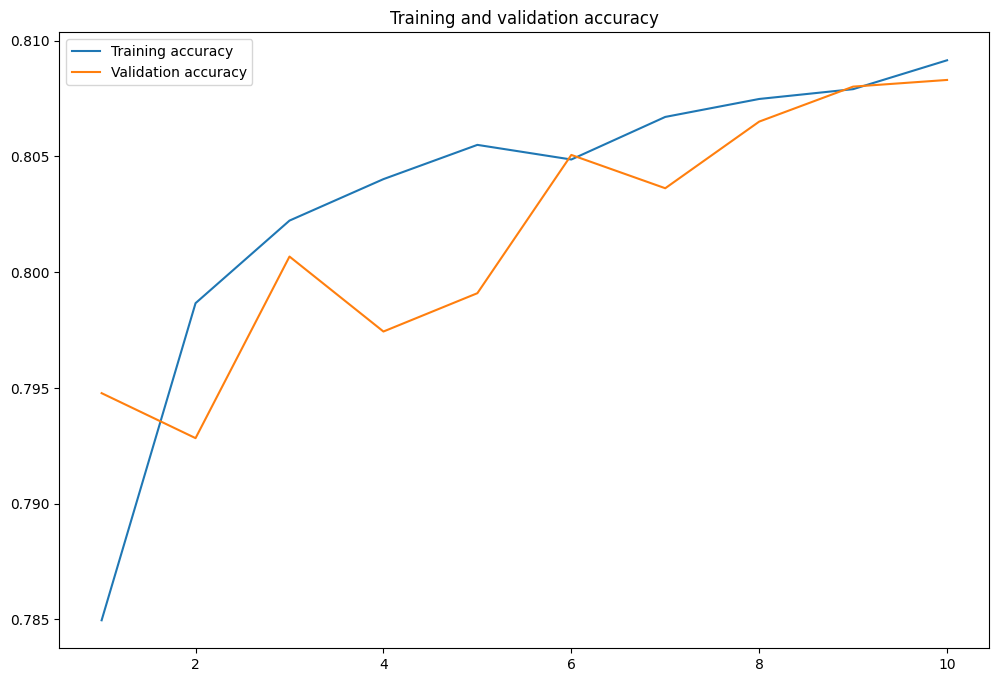

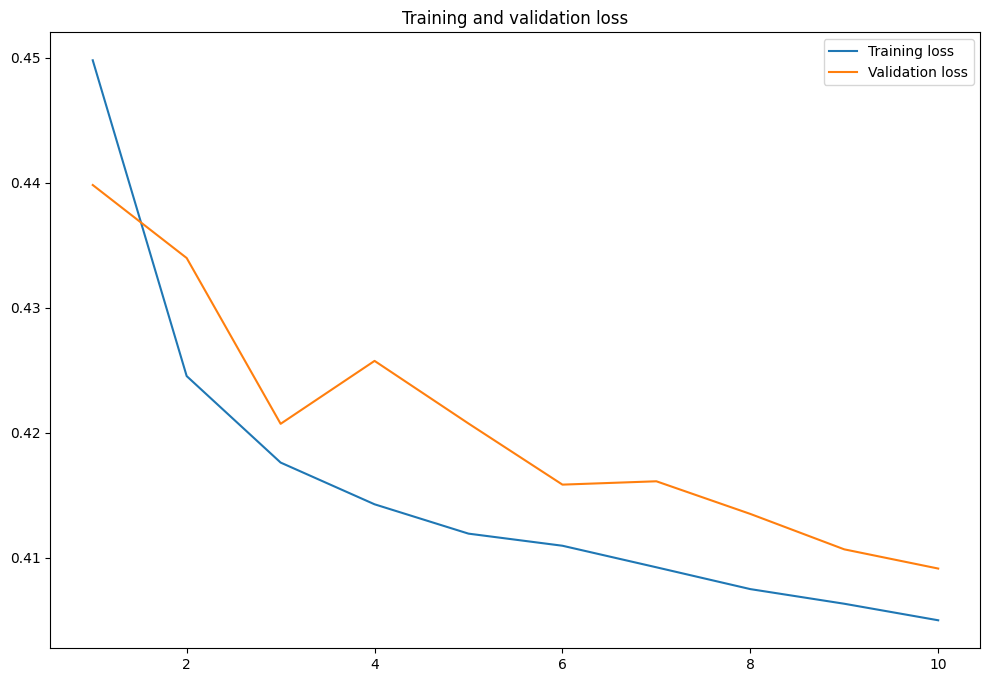

In [62]:
plot_history(history_lstm_1)

In [91]:
test_loss_l1, test_accuracy_l1 =model_lstm_1.evaluate(X_test_reshaped, y_test_reshaped)
print(f"Test accuracy: {test_accuracy_l1}, Test loss: {test_loss_l1}")

   5/1086 [..............................] - ETA: 16s - loss: 0.4724 - accuracy: 0.7812

c:\Users\LEGION\anaconda3\envs\sentiment-analysis-dl\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1086/1086 [==============================] - 16s 15ms/step - loss: 0.4141 - accuracy: 0.8033
Test accuracy: 0.8032584190368652, Test loss: 0.41407647728919983


In [95]:
print(f"Test accuracy: {test_accuracy_l1 * 100:.3f}, Test loss: {test_loss_l1 * 100:.3f}")

Test accuracy: 80.326, Test loss: 41.408


## LSTM ver2

In [64]:
def build_model_lstm_2():
  model = Sequential()

  model.add(LSTM(256, activation='relu', return_sequences=True,
                 input_shape=(1,X_train_reshaped.shape[2])
                 ))
  model.add(LSTM(128, dropout=0.2, activation='relu', return_sequences=True))

  model.add(LSTM(64, dropout=0.2, activation='relu',  return_sequences=True))

  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.0005))
  return model

In [65]:
model_lstm_2 = build_model_lstm_2()
model_lstm_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1, 256)            787456    
                                                                 
 lstm_2 (LSTM)               (None, 1, 128)            197120    
                                                                 
 lstm_3 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dense_5 (Dense)             (None, 1, 1)              65        
                                                                 
Total params: 1,034,049
Trainable params: 1,034,049
Non-trainable params: 0
_________________________________________________________________


In [66]:
history_lstm_2 = model_lstm_2.fit(
    X_train_reshaped, y_train_reshaped, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
7817/7817 [==============================] - 371s 47ms/step - loss: 0.4311 - accuracy: 0.7957 - val_loss: 0.4135 - val_accuracy: 0.8075
Epoch 2/10
7817/7817 [==============================] - 435s 56ms/step - loss: 0.4056 - accuracy: 0.8112 - val_loss: 0.4094 - val_accuracy: 0.8120
Epoch 3/10
7817/7817 [==============================] - 500s 64ms/step - loss: 0.3932 - accuracy: 0.8186 - val_loss: 0.4015 - val_accuracy: 0.8157
Epoch 4/10
7817/7817 [==============================] - 439s 56ms/step - loss: 0.3825 - accuracy: 0.8252 - val_loss: 0.3977 - val_accuracy: 0.8168
Epoch 5/10
7817/7817 [==============================] - 440s 56ms/step - loss: 0.3718 - accuracy: 0.8313 - val_loss: 0.4021 - val_accuracy: 0.8164
Epoch 6/10
7817/7817 [==============================] - 627s 80ms/step - loss: 0.3611 - accuracy: 0.8380 - val_loss: 0.3973 - val_accuracy: 0.8169
Epoch 7/10
7817/7817 [==============================] - 692s 89ms/step - loss: 0.3499 - accuracy: 0.8433 - val_loss: 0

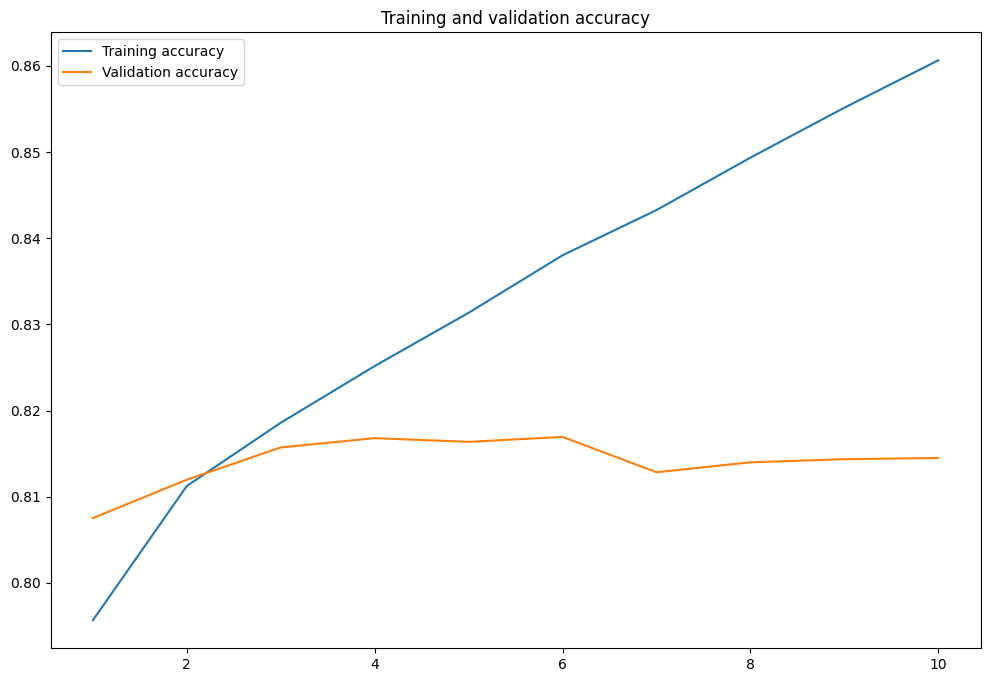

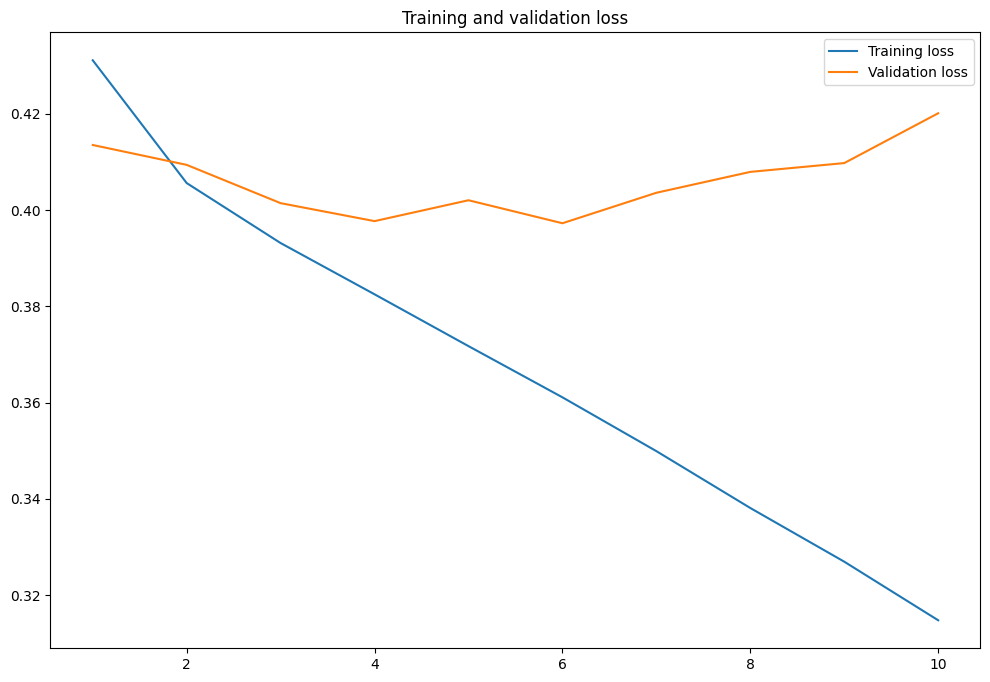

In [67]:
plot_history(history_lstm_2)

In [90]:
test_loss_l2, test_accuracy_l2 =model_lstm_2.evaluate(X_test_reshaped, y_test_reshaped)
print(f"Test accuracy: {test_accuracy_l2}, Test loss: {test_loss_l2}")

   3/1086 [..............................] - ETA: 27s - loss: 0.4535 - accuracy: 0.7812

c:\Users\LEGION\anaconda3\envs\sentiment-analysis-dl\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1086/1086 [==============================] - 29s 27ms/step - loss: 0.4314 - accuracy: 0.8104
Test accuracy: 0.8103969097137451, Test loss: 0.4314248859882355


In [94]:
print(f"Test accuracy: {test_accuracy_l2 * 100:.3f}, Test loss: {test_loss_l2 * 100:.3f}")

Test accuracy: 81.040, Test loss: 43.142


# LSTM 3

In [69]:
def build_model_lstm_3():
    model = Sequential()
    
    model.add(LSTM(256, activation='relu', return_sequences=True,
                   input_shape=(1,X_train_reshaped.shape[2])))
    
    model.add(LSTM(128, dropout=0.2, activation='relu', return_sequences=True))

    model.add(LSTM(64, dropout=0.2, activation='relu', return_sequences=True))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  metrics=['accuracy'],
                  optimizer=Adam(learning_rate=0.0005))
    
    return model

In [70]:
model_lstm_3 = build_model_lstm_3()
model_lstm_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 256)            787456    
                                                                 
 lstm_5 (LSTM)               (None, 1, 128)            197120    
                                                                 
 lstm_6 (LSTM)               (None, 1, 64)             49408     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,034,049
Trainable params: 1,034,049
Non-trainable params: 0
____________________________________________

In [71]:
history_lstm_3 = model_lstm_3.fit(
    X_train_reshaped, y_train_reshaped, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
7817/7817 [==============================] - 454s 58ms/step - loss: 0.4320 - accuracy: 0.7939 - val_loss: 0.4131 - val_accuracy: 0.8048
Epoch 2/10
7817/7817 [==============================] - 444s 57ms/step - loss: 0.4071 - accuracy: 0.8090 - val_loss: 0.4046 - val_accuracy: 0.8108
Epoch 3/10
7817/7817 [==============================] - 443s 57ms/step - loss: 0.3943 - accuracy: 0.8178 - val_loss: 0.4053 - val_accuracy: 0.8102
Epoch 4/10
7817/7817 [==============================] - 420s 54ms/step - loss: 0.3838 - accuracy: 0.8242 - val_loss: 0.3958 - val_accuracy: 0.8155
Epoch 5/10
7817/7817 [==============================] - 477s 61ms/step - loss: 0.3735 - accuracy: 0.8306 - val_loss: 0.3958 - val_accuracy: 0.8163
Epoch 6/10
7817/7817 [==============================] - 818s 105ms/step - loss: 0.3639 - accuracy: 0.8350 - val_loss: 0.3965 - val_accuracy: 0.8144
Epoch 7/10
7817/7817 [==============================] - 639s 82ms/step - loss: 0.3538 - accuracy: 0.8420 - val_loss: 

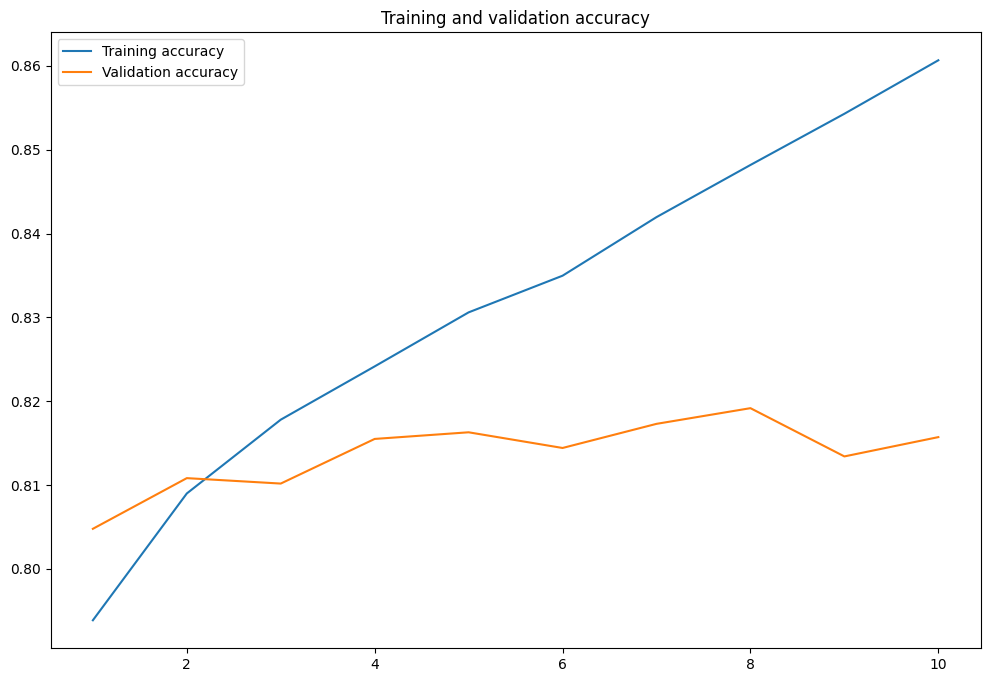

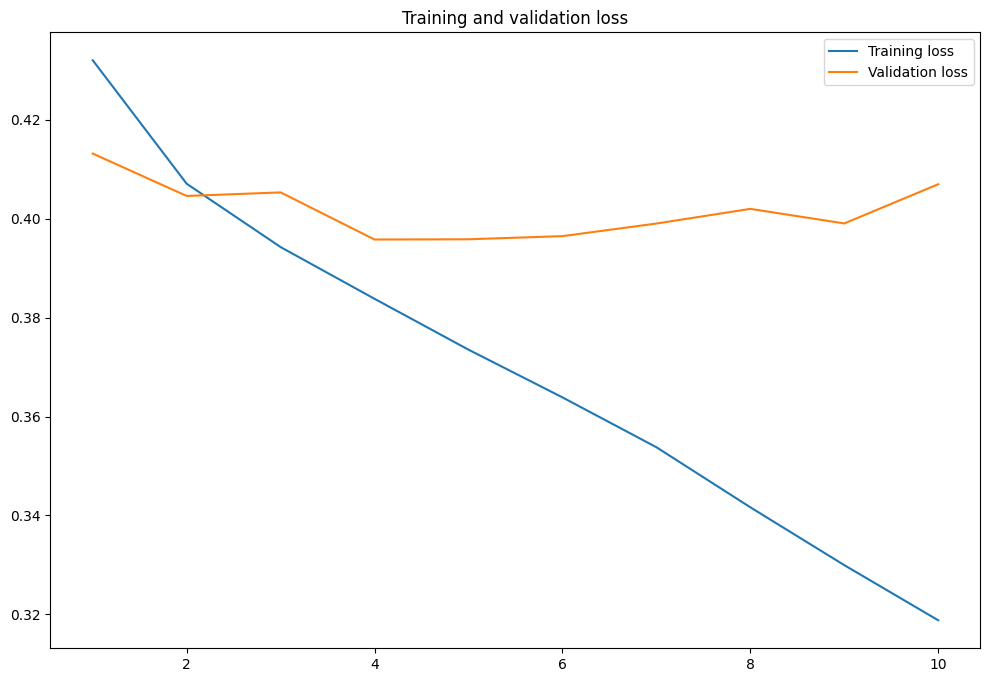

In [72]:
plot_history(history_lstm_3)

In [ ]:
test_loss_l3, test_accuracy_l3 =model_lstm_3.evaluate(X_test_reshaped, y_test_reshaped)
print(f"Test accuracy: {test_accuracy_l3 * 100:.3f}, Test loss: {test_loss_l3 * 100:.3f}")

   3/1086 [..............................] - ETA: 28s - loss: 0.4455 - accuracy: 0.8021

c:\Users\LEGION\anaconda3\envs\sentiment-analysis-dl\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1086/1086 [==============================] - 28s 26ms/step - loss: 0.4201 - accuracy: 0.8118
Test accuracy: 0.8118361830711365, Test loss: 0.42011651396751404


In [93]:
print(f"Test accuracy: {test_accuracy_l3 * 100:.3f}, Test loss: {test_loss_l3 * 100:.3f}")

Test accuracy: 81.184, Test loss: 42.012


# Save Model
---

In [75]:
model_lstm_2.save("lstm_model_2.h5")
model_lstm_3.save("lstm_model_3.h5")

In [87]:
model_lstm_1.save("lstm_model_1.h5")
model_nn.save("nn_model.h5")